# Annotation analysis
Here, we calculate stats for evaluation the annotation quality.  Specifically, percentage (N) of agreement as well as kappa (K) are calculate

In [19]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn

seaborn.set_style("whitegrid")
matplotlib.style.use('seaborn-paper')
matplotlib.rcParams['font.size'] = 14
matplotlib.rcParams['legend.fontsize'] = 14
matplotlib.rcParams['ytick.labelsize'] = 14
matplotlib.rcParams['xtick.labelsize'] = 14
matplotlib.rcParams['axes.labelsize'] = 14
matplotlib.rcParams['axes.titlesize'] = 18

In [20]:
ds = pd.read_csv('data/wdds.csv')
ds.shape

(2097, 18)

In [21]:
ds = ds[~ds.type.isnull()]
ds.shape

(1579, 18)

let's look at the column that indicates the opinion type according to the taxonomy defined in the literature.

In [22]:
labeldist=ds[['row_id','type']].groupby('type').size().reset_index()
labeldist.columns = ['type', 'N']
total = labeldist['N'].sum()
labeldist['perc'] = labeldist['N'] / total
labeldist

,type,N,perc
0,ARGUMENTATIVE,811,0.513616
1,INTERPERSONAL,148,0.093730
2,PERFORMATIVE,620,0.392654


Now, we are going to analyze if there are different labels in each turn (the whole edit made by an author, generally a paragraph)

In [23]:
lblfield='subtype'
lblturns = ds.groupby(['page_id', 'turn']).agg({lblfield:pd.Series.nunique})
lblturns = lblturns.reset_index()
turns = lblturns.groupby(lblfield).count().reset_index()
total = turns.page_id.sum()
turns['perc'] = turns.page_id/float(total)
turns = turns[[lblfield, 'perc']]
turns.columns = ['Number of labels', 'Percentage']
turns.to_csv('output/labelsturnsdist.csv', index=False)
turns

,Number of labels,Percentage
0,1,0.654174
1,2,0.214651
2,3,0.098807
3,4,0.025554
4,5,0.005111
5,6,0.001704


In [24]:
ds.sample(2, random_state=3)

,row_id,page_id,page_title,contributor,timestamp,creation_dt,topic,opinion,clean_opinion,turn,segmentation,type,subtype,type_r1,subtype_r1,type_r2,subtype_r2,url
1255,14,6049652,Nicolás Maduro,186.90.130.150,1484083587,1/10/17 21:26,abandono del cargo,cabe destacar que la asamblea nacional declaro...,cabe destacar que la asamblea nacional declaro...,2,OK,ARGUMENTATIVE,CO,ARGUMENTATIVE,CO,ARGUMENTATIVE,CO,https://es.wikipedia.org/wiki/Discusión:Nicolá...
1848,51,310503,Cristina Fernández de Kirchner,Hendrix-argentina,1333666675,4/5/12 22:57,título de abogado,no creo que haya que modificar nada.,no creo que haya que modificar nada.,26,OK,PERFORMATIVE,PREF,PERFORMATIVE,PREF,ARGUMENTATIVE,CO,https://es.wikipedia.org/wiki/Discusión:Cristi...


## agreement

In [25]:
ds = ds[ds.subtype!='INVALID']
ds = ds[ds.subtype!='SIGN']

In [26]:
from sklearn.metrics import cohen_kappa_score

labels = ds.subtype.unique()
print(f'num labels:{ len(labels)}')

lblfield = 'subtype'
label_f1 = 'subtype_r1'
label_f2 = 'subtype_r2'
aggree_r1 = 'agreement_r1'
aggree_r2 = 'agreement_r2'
aggreement = 'po'
agreement_expected = 'pe'
rndlbl_r1 = 'rndlbl_r1'
rndlbl_r2 = 'rndlbl_r2'
# N
ds[aggree_r1] = ds[lblfield] == ds[label_f1]
ds[aggree_r2] = ds[lblfield] == ds[label_f2]
ds[aggreement] = ds[aggree_r1] & ds[aggree_r2]
# kappa
ds[rndlbl_r1] = ds.subtype.sample(ds.shape[0], random_state=4).values
ds[rndlbl_r2] = ds.subtype.sample(ds.shape[0], random_state=5).values
ds[agreement_expected] = ds[rndlbl_r1] == ds[rndlbl_r2] 

ds[aggreement] = ds[aggreement].apply(lambda x: float(x))
ds[agreement_expected] = ds[agreement_expected].apply(lambda x: float(x))
ds_rs = ds.groupby(lblfield).agg({'row_id': 'count',
                                  aggreement: 'mean',
                                  agreement_expected:'mean'})
ds_rs = ds_rs.reset_index()
ds_rs.columns=['subtype','N', aggreement,agreement_expected]
#ds_rs['kappa'] = cohen_kappa_score(ds[label_f1], ds[label_f2], labels)
ds_rs['kappa'] = (ds_rs[aggreement] - ds_rs[agreement_expected])/(1-ds_rs[agreement_expected])
ds_rs.to_csv('output/agreement.csv', index=False)
ds_rs

num labels:16


,subtype,N,po,pe,kappa
0,ACE,3,0.666667,0.000000,0.666667
1,ATT,148,0.993243,0.162162,0.991935
2,CL,12,0.583333,0.333333,0.375000
3,CM,58,0.810345,0.189655,0.765957
4,CO,617,0.915721,0.202593,0.894309
5,COBJ,29,0.793103,0.137931,0.760000
6,CS,20,0.850000,0.400000,0.750000
7,CU,36,0.666667,0.083333,0.636364
8,CW,36,0.833333,0.222222,0.785714
9,IC,14,0.785714,0.357143,0.666667


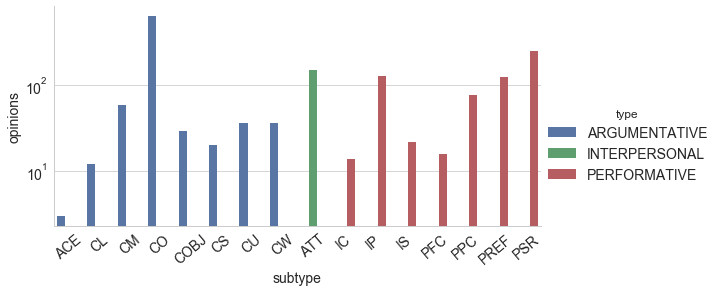

In [27]:
typedist=ds[['row_id','type','subtype']].groupby(['type', 'subtype']).count()
typedist.reset_index(inplace=True)
plt.figure(figsize=(15,3))
fg = seaborn.factorplot(x='subtype', y='row_id', hue='type', 
                        data=typedist, kind='bar', size=4, aspect=2)
#fg.set(axis_bgcolor='w')
fg.set_xticklabels(rotation=40)
plt.yscale('log')
plt.ylabel('opinions')
plt.savefig('output/annotatedopinionsdist.eps', format='eps')